# Машинное обучение

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Загрузка баз данных о ресторанах

In [2]:
air_reserve = pd.read_csv("Data/air_reserve/air_reserve.csv")
air_store_info = pd.read_csv("Data/air_store_info/air_store_info.csv")
air_visit_data = pd.read_csv("Data/air_visit_data/air_visit_data.csv")
date_info = pd.read_csv("Data/date_info/date_info.csv")
hpg_reserve = pd.read_csv("Data/hpg_reserve/hpg_reserve.csv")
hpg_store_info = pd.read_csv("Data/hpg_store_info/hpg_store_info.csv")
sample_submission = pd.read_csv("Data/sample_submission/sample_submission.csv")
store_id_relation = pd.read_csv("Data/store_id_relation/store_id_relation.csv")

## Работа с данными

### Перевод дат в нужный формат

In [3]:
date_info["calendar_date"] = pd.to_datetime(date_info["calendar_date"]).dt.date
air_visit_data["visit_date"] = pd.to_datetime(air_visit_data["visit_date"]).dt.date
hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime']).dt.date



### Объединение двух баз данных в одну таблицу

In [4]:
air_data = pd.merge(air_visit_data, air_store_info, on='air_store_id', how='left')
hpg_reserve.drop(columns=["reserve_datetime"], inplace=True)


hpg_reserve = hpg_reserve.groupby(['hpg_store_id', 'visit_datetime']).agg({'reserve_visitors' : 'sum'}).reset_index()
hpg_reserve.to_csv('hpg_reserve_new.csv', index=False)


hpg_data = pd.merge(hpg_reserve, hpg_store_info, on='hpg_store_id', how='left')

air_data = air_data.rename(columns={'air_store_id': 'store_id', 'air_genre_name': 'genre_name', 'air_area_name': 'area_name'})
hpg_data = hpg_data.rename(columns={'hpg_store_id': 'store_id', 'visit_datetime': 'visit_date', 'reserve_visitors': 'visitors', 'hpg_genre_name': 'genre_name', 'hpg_area_name': 'area_name'})

store_id_relation = store_id_relation.reindex(columns=['hpg_store_id', 'air_store_id'])
store_id_relation = store_id_relation.to_dict('split')

dict_ = dict(store_id_relation['data'])
hpg_data.replace({'store_id' : dict_}, inplace=True)

all_data = pd.concat([air_data, hpg_data], ignore_index=True)

all_data = all_data.sort_values(by='visit_date')
all_data = all_data.groupby(['store_id', 'visit_date'], as_index=False).agg({
    'genre_name': 'first',  # сохраняем первый жанр 
    'area_name': 'first',  # сохраняем первую область 
    'latitude': 'first',  # сохраняем первую широту 
    'longitude': 'first',  # сохраняем первую долготу 
    'visitors': 'sum'  # суммируем значения в столбце 'visitors'
})

C:\Users\yasch\AppData\Local\Temp\ipykernel_7676\717490739.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_data['genre_name'].fillna('Unknown', inplace=True)
C:\Users\yasch\AppData\Local\Temp\ipykernel_7676\717490739.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

### Заполнение пропущенных данных

In [ ]:
all_data['genre_name'].fillna('Unknown', inplace=True)
all_data['area_name'].fillna('Unknown', inplace=True)

total_data = pd.merge(all_data, date_info, left_on="visit_date", right_on="calendar_date", how="left")
total_data.drop(columns=["calendar_date"], inplace=True)
total_data["month"] = pd.to_datetime(total_data["visit_date"]).dt.month


### Вычисляем средние значения признаков

In [5]:
total_data["visitors_per_restaurant"] = total_data.groupby("store_id")["visitors"].transform("mean")
total_data["visitors_per_day_of_week"] = total_data.groupby("day_of_week")["visitors"].transform("mean")
total_data["visitors_per_month"] = total_data.groupby("month")["visitors"].transform("mean")
total_data["visitors_per_genre_name"] = total_data.groupby("genre_name")["visitors"].transform("mean")
total_data["visitors_per_area_name"] = total_data.groupby("area_name")["visitors"].transform("mean")

### Информация о полученных данных

In [6]:
statistic = total_data["visitors"].agg(["min", "median", "max"])
print(f"Минимум: {statistic['min']}; Медиана: {statistic['median']}; Максимум: {statistic['max']}")

rows = total_data["visitors"].count()
print(f"Количество строк: {rows}")

Минимум: 1.0; Медиана: 6.0; Максимум: 877.0
Количество строк: 1593611


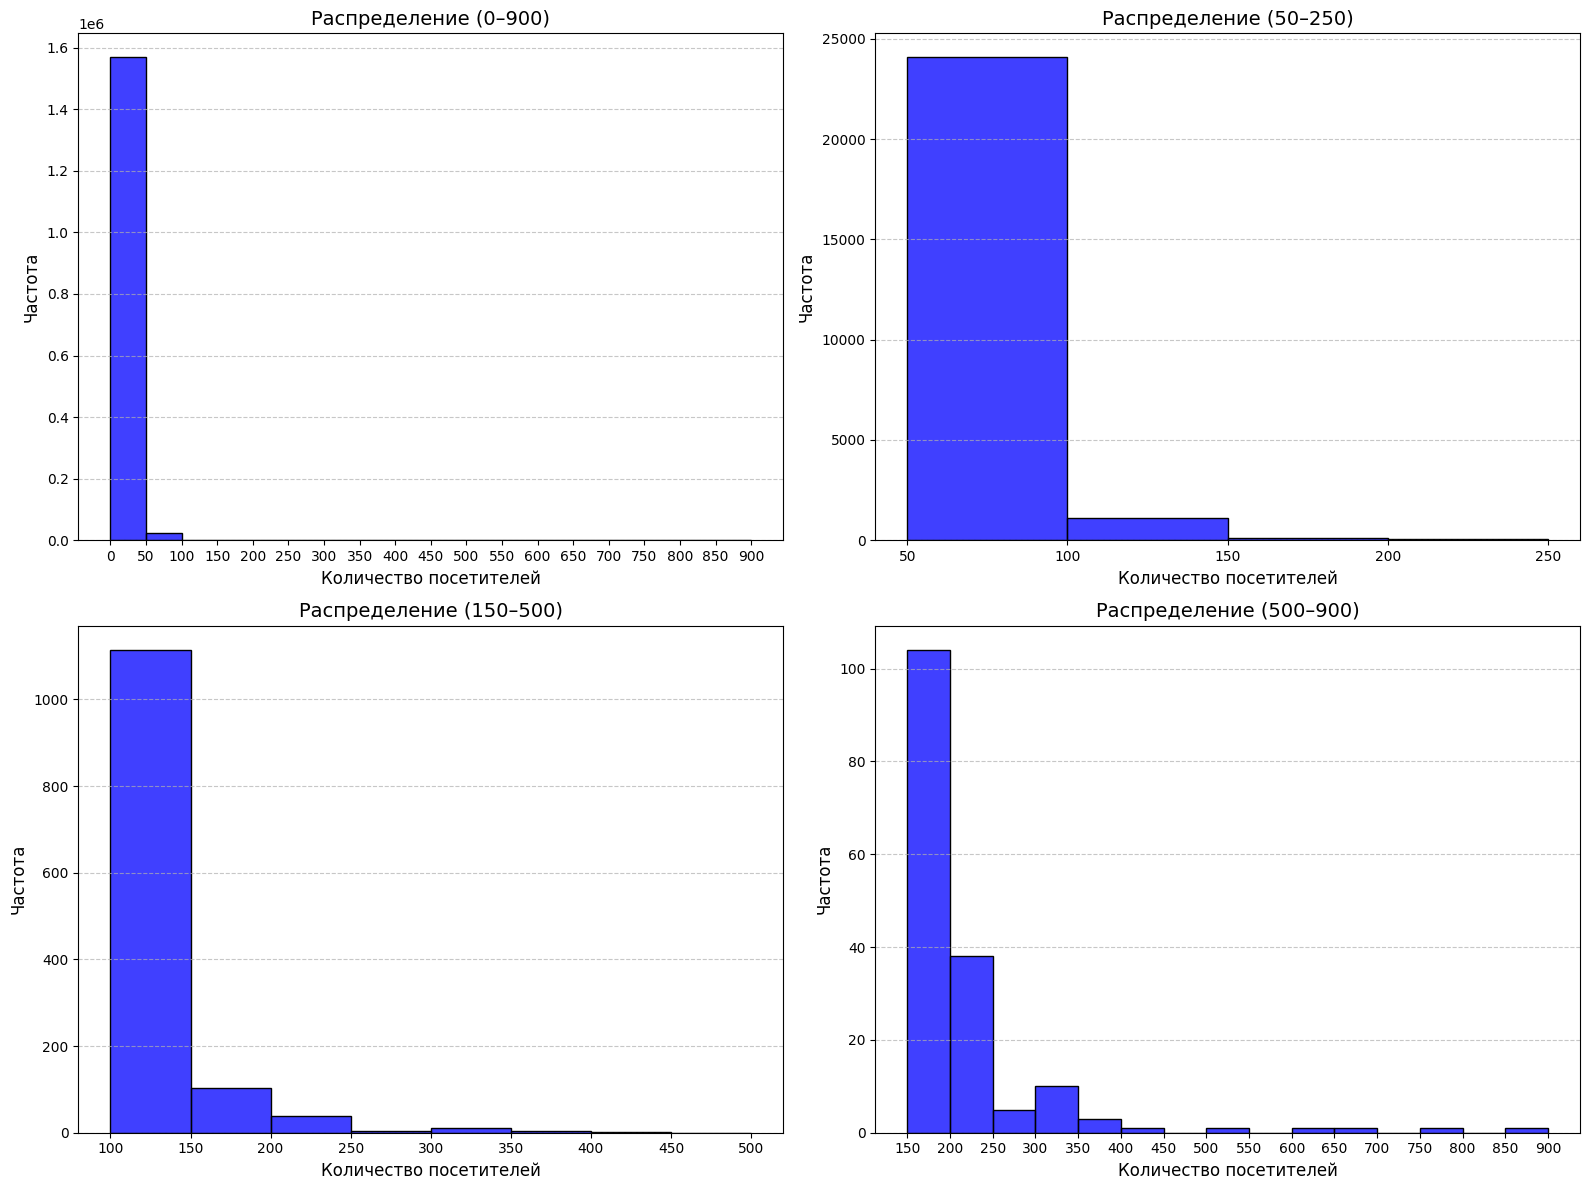

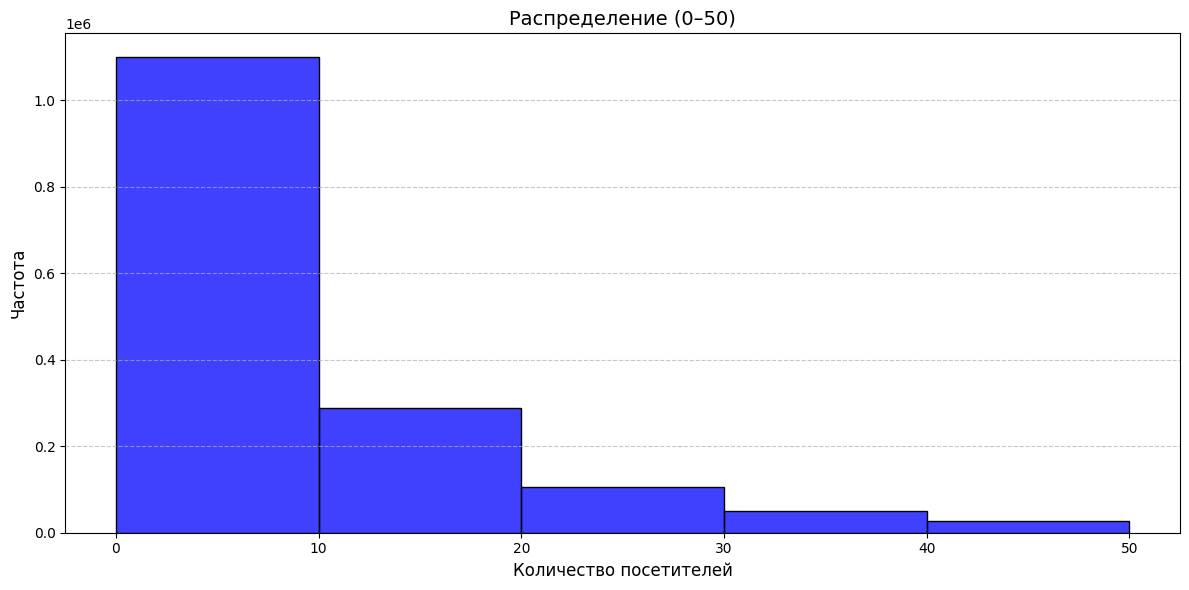

In [7]:
# Создание фигуры с четырьмя графиками
plt.figure(figsize=(16, 12))  # Увеличиваем размер для размещения 4 графиков

# График 1: Полный диапазон (0–900)
plt.subplot(2, 2, 1)
sns.histplot(total_data["visitors"], bins=range(0, 901, 50), color="blue", edgecolor="black")
plt.title("Распределение (0–900)", fontsize=14)
plt.xlabel("Количество посетителей", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.xticks(range(0, 901, 50))
plt.grid(axis="y", linestyle="--", alpha=0.7)

# График 2: Диапазон (50–250)
plt.subplot(2, 2, 2)
sns.histplot(total_data["visitors"], bins=range(50, 251, 50), color="blue", edgecolor="black")
plt.title("Распределение (50–250)", fontsize=14)
plt.xlabel("Количество посетителей", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.xticks(range(50, 251, 50))
plt.grid(axis="y", linestyle="--", alpha=0.7)

# График 3: Диапазон (150–500)
plt.subplot(2, 2, 3)
sns.histplot(total_data["visitors"], bins=range(100, 501, 50), color="blue", edgecolor="black")
plt.title("Распределение (150–500)", fontsize=14)
plt.xlabel("Количество посетителей", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.xticks(range(100, 501, 50))
plt.grid(axis="y", linestyle="--", alpha=0.7)

# График 4: Диапазон (500–900)
plt.subplot(2, 2, 4)
sns.histplot(total_data["visitors"], bins=range(150, 901, 50), color="blue", edgecolor="black")
plt.title("Распределение (500–900)", fontsize=14)
plt.xlabel("Количество посетителей", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.xticks(range(150, 901, 50))
plt.grid(axis="y", linestyle="--", alpha=0.7)



# Корректировка расположения
plt.tight_layout()

# Отображение графиков
plt.show()

# График 2: Диапазон (0–50)
plt.figure(figsize=(12, 6))
sns.histplot(total_data["visitors"], bins=range(0, 51, 10), color="blue", edgecolor="black")
plt.title("Распределение (0–50)", fontsize=14)
plt.xlabel("Количество посетителей", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.xticks(range(0, 51, 10))
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Корректировка расположения
plt.tight_layout()

# Отображение графиков
plt.show()


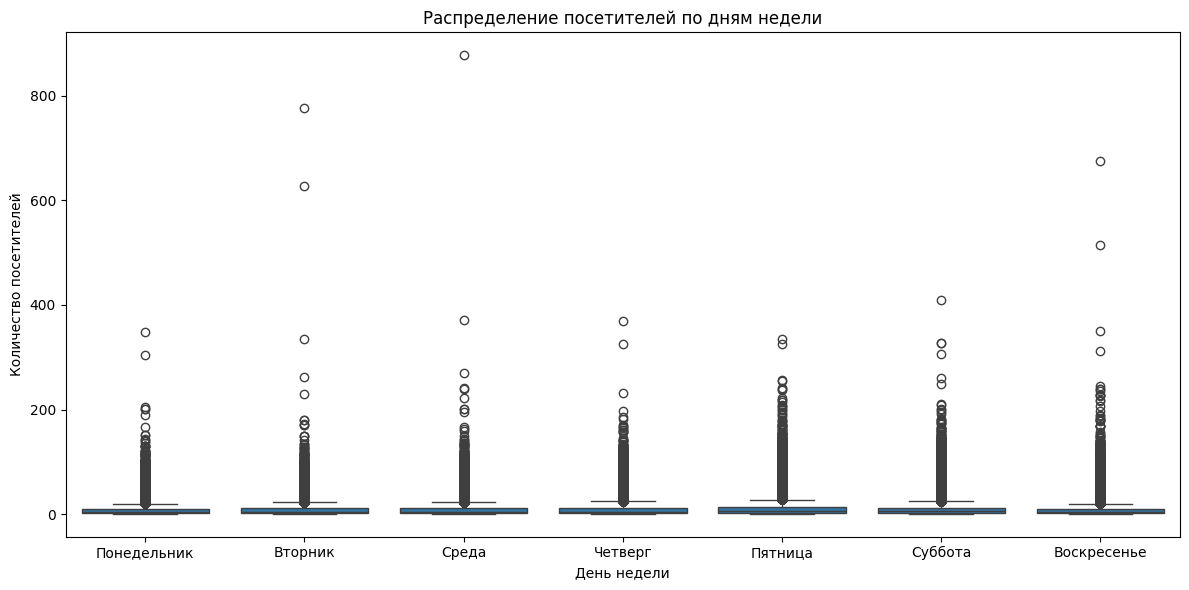

In [8]:
total_data['day_of_week_num'] = pd.to_datetime(total_data["visit_date"]).dt.dayofweek

# График посетителей по дням недели
plt.figure(figsize=(12, 6))
days = ['Понедельник', 'Вторник', 'Среда', 'Четверг',
        'Пятница', 'Суббота', 'Воскресенье']
sns.boxplot(data=total_data, x='day_of_week_num', y='visitors', order=range(7))
plt.xticks(range(7), days, rotation=0)
plt.title('Распределение посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество посетителей')
plt.tight_layout()
plt.show()

### Разделение на обучающую и тестовую выборки

In [9]:
df = total_data.copy()

df["store_id"] = df["store_id"].map(df["store_id"].value_counts(normalize=True))
df["area_name"] = df["area_name"].map(df["area_name"].value_counts(normalize=True))
df["genre_name"] = df["genre_name"].map(df["genre_name"].value_counts(normalize=True))
df["day_of_week"] = df["day_of_week"].map(df["day_of_week"].value_counts(normalize=True))
df["month"] = df["month"].map(df["month"].value_counts(normalize=True))


In [10]:
features = ["store_id", "day_of_week", "holiday_flg", "genre_name", "area_name", 
            "month", "visitors_per_restaurant", "visitors_per_day_of_week", "visitors_per_month", 
            "visitors_per_genre_name", "visitors_per_area_name"]

x = df[features]
y = df['visitors']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Подбор параметров для моделей обучения

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor


# Создаем модель решающего дерева
dt_model = DecisionTreeRegressor(random_state=42)


param_dist_dt = {
    'max_depth': [1, 5, 10, 20],  # Глубина дерева от 1 до 20
    'min_samples_split': [2, 5, 10, 20],  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [1, 5, 10, 20],  # Минимальное количество образцов в листьях
    'max_features': ['auto', 'sqrt', 'log2', None],  # Количество признаков, которое использовать для разделения
    'criterion': ['friedman_mse', 'absolute_error']  # Критерий для разбиения
}

random_search_dt = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist_dt,
    n_iter=10,  # Количество случайных комбинаций гиперпараметров для подбора
    scoring='neg_mean_squared_error',  # Оценка качества модели
    cv=3,  # Кросс-валидация
    random_state=42,
    n_jobs=-1,  # Используем все доступные ядра для параллельной обработки
    verbose=2
)

# Обучаем модель
random_search_dt.fit(x_train, y_train)

# Лучшие параметры
print("Лучшие параметры для решающего дерева:", random_search_dt.best_params_)

# Для решающего дерева
best_dt_model = random_search_dt.best_estimator_
dt_test_score = best_dt_model.score(x_test, y_test)

print(f"Тестовая оценка решающего дерева: {dt_test_score}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Создаем модель градиентного бустинга
gb_model = GradientBoostingRegressor(random_state=42)

param_dist_gb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 6, 8],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

random_search_gb = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist_gb,
    n_iter=50,  # Количество случайных комбинаций гиперпараметров для подбора
    scoring='neg_mean_squared_error',  # Оценка качества модели
    cv=5,  # Кросс-валидация
    random_state=42,
    n_jobs=-1,  # Используем все доступные ядра для параллельной обработки
    verbose=2
)

# Обучаем модель
random_search_gb.fit(x_train, y_train)

# Лучшие параметры
print("Лучшие параметры для градиентного бустинга:", random_search_gb.best_params_)

# Для градиентного бустинга
best_gb_model = random_search_gb.best_estimator_
gb_test_score = best_gb_model.score(x_test, y_test)

print(f"Тестовая оценка градиентного бустинга: {gb_test_score}")

## Машинное обучение

### Модель деревьев решений

In [43]:
from sklearn.tree import DecisionTreeRegressor

# Задаем параметры модели
dt_model = DecisionTreeRegressor(
    max_depth=14, 
    min_samples_split=2, 
    min_samples_leaf=20, 
    criterion='squared_error',
    random_state=42
)

# Обучаем модель
dt_model.fit(x_train, y_train)

# Оценка модели на тестовых данных
dt_test_score = dt_model.score(x_test, y_test)
print(f"Тестовая оценка решающего дерева: {dt_test_score}")

Тестовая оценка решающего дерева: 0.43224747604536873


### Модель градиентного бустинга

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

# Модель для малых ресторанов
model = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=2,
    subsample=0.8,
    random_state=42
)
model.fit(x_train, y_train)

# Предсказания
y_pred = model.predict(x_test)

In [15]:
# Оценка модели на тестовых данных
gb_test_score = model.score(x_test, y_test)
print(f"Тестовая оценка градиентного бустинга: {gb_test_score}")

Тестовая оценка градиентного бустинга: 0.44984202985279764


### Ошибки модели

In [57]:
# Предсказания на тестовых данных
dt_predictions = dt_model.predict(x_test)

# Оценка качества
dt_mse = mean_squared_error(y_test, dt_predictions)
gb_mse = mean_squared_error(y_test, y_pred)
dt_mae = mean_absolute_error(y_test, dt_predictions)
gb_mae = mean_absolute_error(y_test, y_pred)

print(f"Среднеквадратическая ошибка для решающего дерева: {dt_mse}")
print(f"Среднеквадратическая ошибка для градиентного бустинга: {gb_mse}")
print()
print(f"Средняя абсолютная ошибка для решающего дерева: {dt_mae}")
print(f"Средняя абсолютная ошибка для градиентного бустинга: {gb_mae}")

Среднеквадратическая ошибка для решающего дерева: 75.82920887811748
Среднеквадратическая ошибка для градиентного бустинга: 73.47927463830524

Средняя абсолютная ошибка для решающего дерева: 5.251348122486059
Средняя абсолютная ошибка для градиентного бустинга: 5.181996502292043


## Анализ результатов

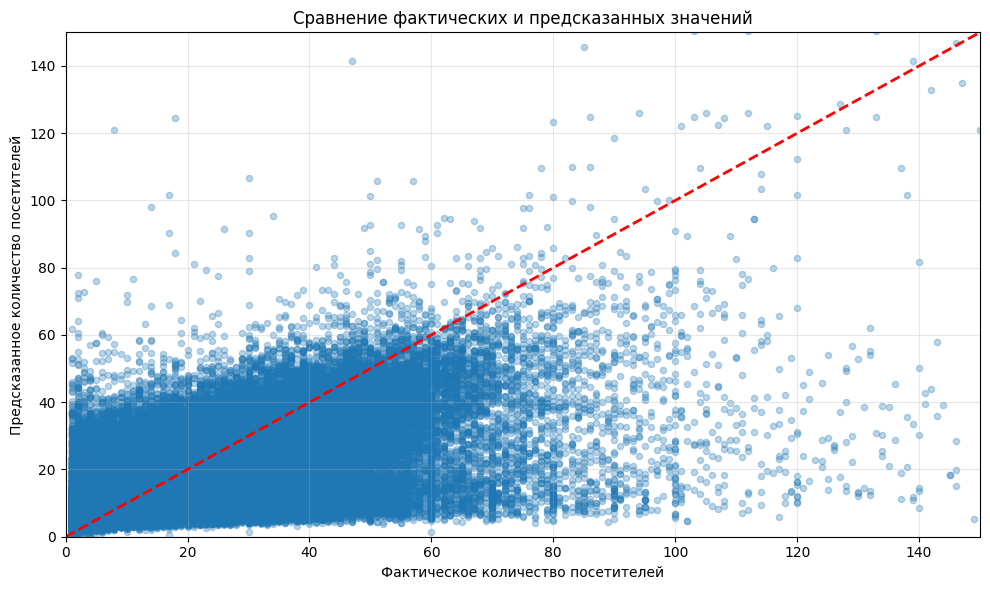

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, s=20)
plt.plot([0, 150], [0, 150], 'r--', lw=2)
plt.xlim(0, 150)
plt.ylim(0, 150)
plt.xlabel('Фактическое количество посетителей')
plt.ylabel('Предсказанное количество посетителей')
plt.title('Сравнение фактических и предсказанных значений (градиентный бустинг)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

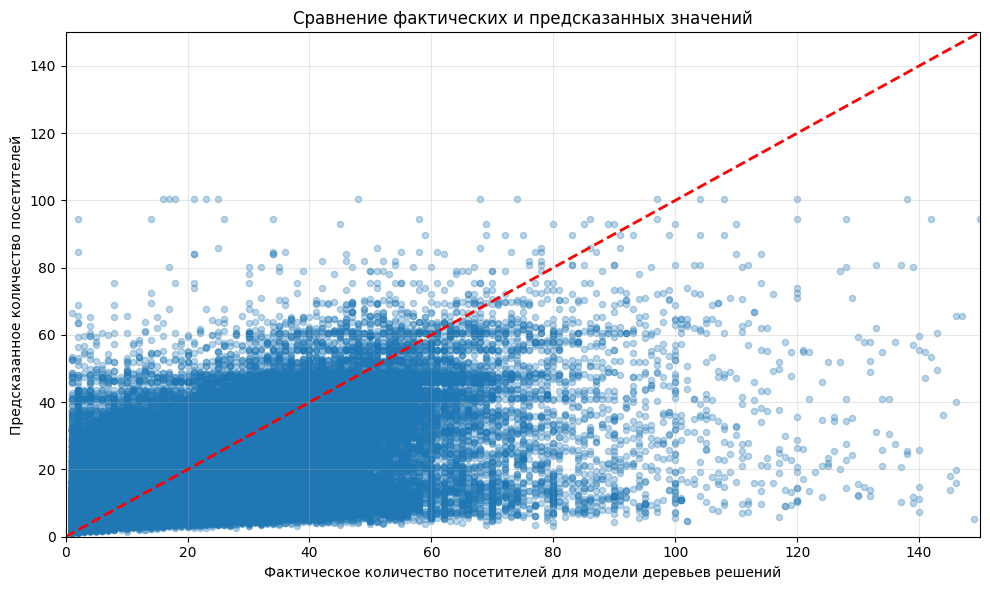

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, dt_predictions, alpha=0.3, s=20)
plt.plot([0, 150], [0, 150], 'r--', lw=2)
plt.xlim(0, 150)
plt.ylim(0, 150)
plt.xlabel('Фактическое количество посетителей')
plt.ylabel('Предсказанное количество посетителей')
plt.title('Сравнение фактических и предсказанных значений (деревья решений)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

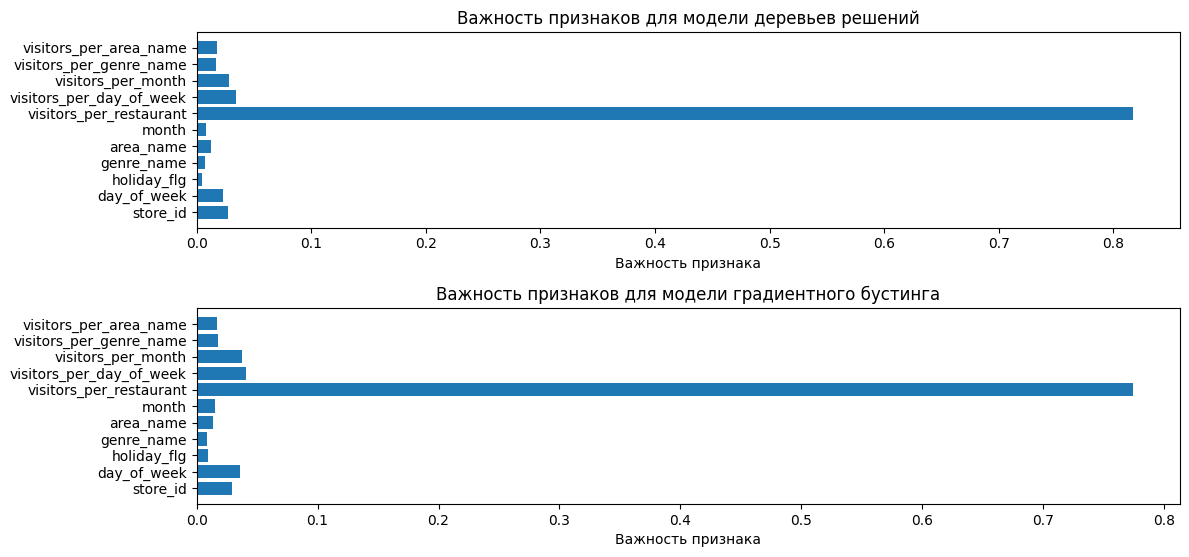

In [48]:
plt.figure(figsize=(12, 8))

# Важность признаков для малых ресторанов
importances_dt = pd.DataFrame({
    'feature': features,
    'importance': dt_model.feature_importances_,
    'model': ['Деревья решений'] * len(features)
})

# Важность признаков для малых ресторанов
importances_gb = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_,
    'model': ['Градиентный бустинг'] * len(features)
})

importances = pd.concat([importances_dt, importances_gb])
importances = importances.sort_values(['model', 'importance'], ascending=[True, True])

plt.subplot(311)
plt.barh(range(len(features)), importances_dt['importance'])
plt.yticks(range(len(features)), importances_dt['feature'])
plt.xlabel('Важность признака')
plt.title('Важность признаков для модели деревьев решений')

plt.subplot(312)
plt.barh(range(len(features)), importances_gb['importance'])
plt.yticks(range(len(features)), importances_gb['feature'])
plt.xlabel('Важность признака')
plt.title('Важность признаков для модели градиентного бустинга')


plt.tight_layout()
plt.show()


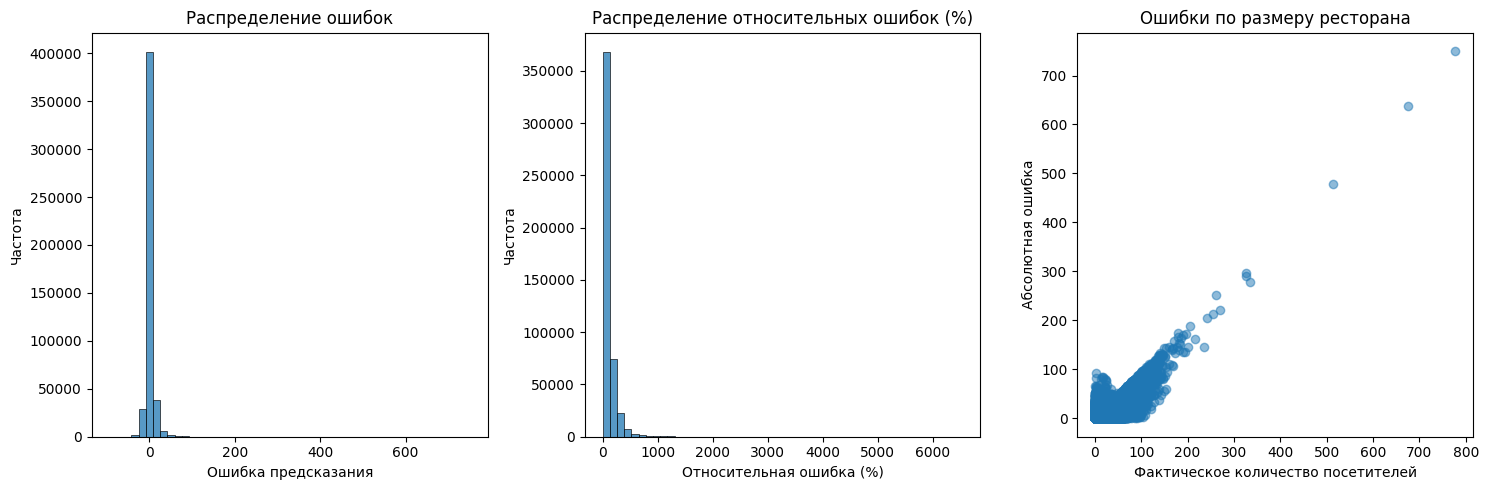

In [52]:
# Анализ ошибок предсказания для деревьев решений
y_test_combined = y_test
y_pred_combined = dt_predictions

errors = y_test_combined - y_pred_combined
relative_errors = np.abs(errors / y_test_combined) * 100

plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(errors, bins=50)
plt.title('Распределение ошибок')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')

plt.subplot(132)
sns.histplot(relative_errors, bins=50)
plt.title('Распределение относительных ошибок (%)')
plt.xlabel('Относительная ошибка (%)')
plt.ylabel('Частота')

plt.subplot(133)
plt.scatter(y_test_combined, np.abs(errors), alpha=0.5)
plt.xlabel('Фактическое количество посетителей')
plt.ylabel('Абсолютная ошибка')
plt.title('Ошибки по размеру ресторана')

plt.tight_layout()

In [53]:
print(f'Средняя абсолютная ошибка: {np.mean(np.abs(errors)):.2f}')
print(f'Медианная абсолютная ошибка: {np.median(np.abs(errors)):.2f}')
print(f'Средняя относительная ошибка: {np.mean(relative_errors):.2f}%')
print(f'Медианная относительная ошибка: {np.median(relative_errors):.2f}%')

Средняя абсолютная ошибка: 5.25
Медианная абсолютная ошибка: 3.37
Средняя относительная ошибка: 95.10%
Медианная относительная ошибка: 53.23%


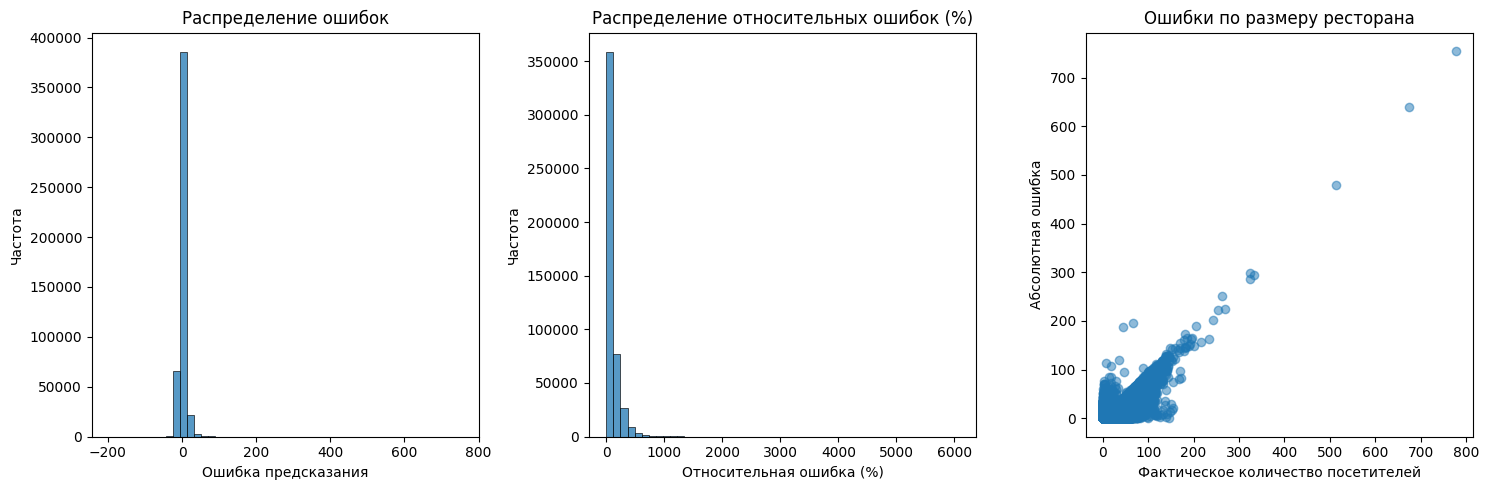

In [54]:
# Анализ ошибок предсказания для градиентного бустинга
y_test_combined = y_test
y_pred_combined = y_pred

errors = y_test_combined - y_pred_combined
relative_errors = np.abs(errors / y_test_combined) * 100

plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(errors, bins=50)
plt.title('Распределение ошибок')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')

plt.subplot(132)
sns.histplot(relative_errors, bins=50)
plt.title('Распределение относительных ошибок (%)')
plt.xlabel('Относительная ошибка (%)')
plt.ylabel('Частота')

plt.subplot(133)
plt.scatter(y_test_combined, np.abs(errors), alpha=0.5)
plt.xlabel('Фактическое количество посетителей')
plt.ylabel('Абсолютная ошибка')
plt.title('Ошибки по размеру ресторана')

plt.tight_layout()

In [55]:
print(f'Средняя абсолютная ошибка: {np.mean(np.abs(errors)):.2f}')
print(f'Медианная абсолютная ошибка: {np.median(np.abs(errors)):.2f}')
print(f'Средняя относительная ошибка: {np.mean(relative_errors):.2f}%')
print(f'Медианная относительная ошибка: {np.median(relative_errors):.2f}%')

Средняя абсолютная ошибка: 5.18
Медианная абсолютная ошибка: 3.36
Средняя относительная ошибка: 94.90%
Медианная относительная ошибка: 53.28%
